## CNN Image Classification: HAM10000

### Les objectifs de construction du model

Il y a trois objectifs principaux pour ce projet impliquant la construction d'un modèle de classification d'images séquentielles Keras sur un ordinateur portable.

Mais tout d'abord, examinons les problèmes que posent ces données et les ressources disponibles. <br>
Le problème majeur est que les données sont fortement biaisées en faveur d'une seule classe (les nevus mélanocytaires [nv]) sur sept, qui représente 67% des données, comme le montre le comptage des types de cellules dans la section 3.1. D'autres facteurs incluent une taille de jeu de données quelque peu limitée pour la classification d'images. De plus, l'architecture du model et ses performances ultérieures sont affectées par la réduction de la résolution des images [de 600x400 à 160x120] et une quantité limitée de mémoire de ressources (c'est-à-dire de puissance de calcul).<br>

Les objectifs sont les suivants :<br>

    1) réduire considérablement ou éliminer le overfitting.
    2) atteindre au moins une précision de test proche de 80 % sans violer le premier objectif.
    3) construire un model qui puisse fonctionner avec des ressources limitées tout en atteignant l'objectif 2.

## Table des matières

1. Chargement des bibliothèques<br>
2. Lecture et traitement des données<br>
   2.1 Examen du contenu du HAM1000<br>
   2.2 Lecture des métadonnées et encodage des lables<br>
3. Fusion des dossiers d'images et création d'un dictionnaire de types de lésions<br>
4. Ajout de nouvelles colonnes<br>
5. Nettoyage du Data<br>
   5.1 info<br>
   5.2 Recherche des valeurs manquantes indiquées dans ham_df.info()<br>
   5.3 Utilisation de la moyenne d'âge pour remplir les valeurs manquantes d'Age<br>
   5.3.1  Re-vérifier pour s'assurer que toutes les données sont présentes
6. Analyse exploratoire des données (EDA)<br>
   6.1 Comptage des types de cellules<br>
   6.2 Distribution d'Age<br>
   6.3 Distribution d'Age par Sexe <br>
   6.4 Comptage des types de cellules par Sexe <br>
   6.5 Types de lésions par âge et sexe<br>
   6.7 CountPlot: Comptage des types de cellules par Age<br>
7. Redimensionnement des images<br>
   7.1 Comparaison des caractéristiques de taille d'image<br>
   7.2 Redimensionnement des images pour l'entrée du modèle<br>
   7.3 Un échantillon d'images de skin lesion<br>
8. Prétraitement<br>
   8.1 Entraînement Test Validation<br>
   8.1.1 Split : train / test = 80 / 20<br>
   8.1.2 Conversion en tableau Numpy<br>
   8.1.3 Standardisation<br>
   8.1.4 Encodage one-hot : conversion de l'output to categorical crossentropy<br>
   8.1.5 Split : train / validation = 0,87 / 0,13<br>
   8.1.6 Reshape des images en 3 dimensions<br>
9. Test du model (modelT)<br>
   9.1 Test de l'architecture du model<br>
   9.1.1 Entraînement de modelT avec augmentation <br>
   9.1.2 Évaluation de la précision et de la perte de test de modelT <br>
   9.1.3 Tracés de l'Accuracy  et de Loss Plots du test model après l'augmentation<br>

In [7]:
import tensorflow as tf

# 1. Chargement des bibliothèques

In [8]:
import numpy as np

In [9]:
# Utilisons "%matplotlib inline" pour permettre une coordination efficace entre KaggleNotebook et matplotlib et afficher les graphiques dans le notebook.
%matplotlib inline

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D #, GlobalAveragePooling2D
from keras import optimizers
from keras.optimizers import Adam  #, SGD

from tensorflow.keras.layers import BatchNormalization

from keras.metrics import categorical_crossentropy
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau #,EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.regularizers import l2 #, l1 
from keras import initializers #he_normal

In [10]:
import seaborn as sns
from PIL import Image
import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import shutil
import itertools
from glob import glob
from numpy.random import seed

import pydot
import time
import cv2 

In [11]:
import autoreload 

%load_ext watermark
%load_ext autoreload
%autoreload 2

%watermark -a 'WForsythe' -d -t -v -p numpy,pandas,keras,sklearn,tensorflow,seaborn,cv2

ModuleNotFoundError: No module named 'watermark'

**%load_ext watermark**: charge une extension qui ajoute une horodatage et d'autres informations système à la sortie du notebook.

**%load_ext autoreload**: charge une extension qui recharge automatiquement les modules importés, chaque fois que des modifications sont apportées au code source du module.

**%autoreload 2**: définit le mode de rechargement automatique pour recharger tous les modules (sauf ceux exclus par %aimport) à chaque exécution du code Python tapé.

**%watermark**: affiche la date et l'heure actuelles, les numéros de version de tous les packages Python listés après -p, et le nom de l'auteur spécifié avec le -a.

# 2. Lecture et traitement des données

**Data Source:**<br>
    * Auteur: Mader, K<br>
    * Titre: Skin Cancer MNIST: HAM10000, une collection importante d'images dermatoscopiques provenant de diverses sources, qui sont des lésions pigmentées de la peau.<br>
    * Date: 2019<br>
    * Disponiblité: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000<br>

## 2.1 Examen du contenu du HAM1000<br>
   
les seules fichiers et dossiers de HAM10000 que nous sommes besoin pour réaliser ce projet sont les 2 dossiers des images et le fichier metadata.

In [ ]:
ham_folder = '/kaggle/input/skin-cancer-mnist-ham10000'
print(os.listdir(ham_folder))

## 2.2 Lecture des metadata et encodage des lables<br>

    Cette opération inclut la création d'une nouvelle colonne avec des labels dx converties en classe de nombres.
    La plupart du script suivant était disponible à partir de plusieurs sources.

In [ ]:
# Source: https://github.com/00chengh/Skin-Cancer-HAM10000/blob/master/Final%20Capstone%20-%20Skin%20Cancer.ipynb
# Source: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
# Source: https://www.kaggle.com/hashbanger/skin-lesion-identification

metadata = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
print(metadata.shape)

lab_enc = LabelEncoder()
lab_enc.fit(metadata['dx'])
LabelEncoder()
print(list(lab_enc.classes_))
 
metadata['label'] = lab_enc.transform(metadata["dx"]) # converties en classe de nombres.
metadata.head(10)

# 3. Fusion des dossiers d'images et création d'un dictionnaire de types de lésions<br>

In [12]:
# Source: https://github.com/00chengh/Skin-Cancer-HAM10000/blob/master/Final%20Capstone%20-%20Skin%20Cancer.ipynb
# Source: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
# Source: https://www.kaggle.com/hashbanger/skin-lesion-identification

base_folder = os.path.join('..', ham_folder)

# Fusion des dossiers des images HAM10000_images_part1 and HAM10000_images_part2  

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_folder, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# 4. Ajout de nouvelles colonnes
    

In [13]:
# Source: https://github.com/00chengh/Skin-Cancer-HAM10000/blob/master/Final%20Capstone%20-%20Skin%20Cancer.ipynb
# Source: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
# Source: https://www.kaggle.com/hashbanger/skin-lesion-identification

ham_df = pd.read_csv(os.path.join(base_folder, 'HAM10000_metadata.csv'))

# Create new columns
ham_df['path'] = ham_df['image_id'].map(imageid_path_dict.get) # on Map les paths des images à l'image_ids
ham_df['cell_type'] = ham_df['dx'].map(lesion_type_dict.get) # Créer une colonne de 'cell_type' à partir de dx avec les noms de classe complets
ham_df['cell_type_idx'] = pd.Categorical(ham_df['cell_type']).codes # Convertie cell type au categorical

In [14]:
ham_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0


In [15]:
ham_df.dx.unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

# 5. Nettoyage du Data<br>

## 5.1 info

In [16]:
ham_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


## 5.2 Recherche des valeurs manquantes indiquées dans ham_df.info()<br>

In [17]:
ham_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

## 5.3 Utilisation de la moyenne d'Age pour remplir les valeurs manquantes d'âge<br>

In [18]:
ham_df['age'].fillna((ham_df['age'].mean()), inplace=True)
ham_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

### 5.3.1  Re-vérifier pour s'assurer que toutes les données sont présentes

In [19]:
ham_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            10015 non-null  float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


# 6. Analyse exploratoire des données (EDA)<br>
L'Analyse Exploratoire du Data (EDA) a été large, la considération principale est les différences relatives entre les comptages de types de cellules.

##### Figures adapter de: 
https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html<br>
https://flynn.gg/blog/better-matplotlib-charts/<br>
https://seaborn.pydata.org/tutorial/categorical.html<br>
https://seaborn.pydata.org/examples/grouped_boxplot.html<br>

## 6.1 Comptage des types de cellules

Cet ensemble de données d'images est hautement déséquilibré, les nævi mélanocytaires, remplissant 67% de l'espace. Entre le biais de déséquilibre, la réduction de la taille de l'image de 650x450 à 160x120 (soit une réduction de 93% du nombre de pixels) et la similarité des couleurs d'image, ce problème de classification est un exercice particulièrement difficile en ce qui concerne l'exactitude du modèle.

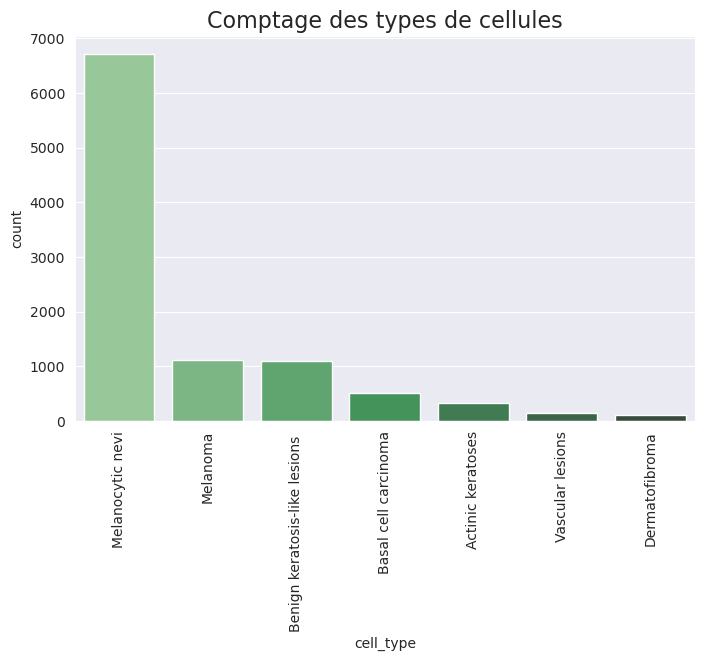

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64


In [20]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.countplot(x = ham_df['cell_type'], 
                     order = ham_df['cell_type'].value_counts().index, 
                     palette= "Greens_d")
plt.xticks(rotation = 90) 
plt.title('Comptage des types de cellules',fontsize=16) 
plt.show()
print(ham_df['cell_type'].value_counts())

## 6.2 Distribution d'Age

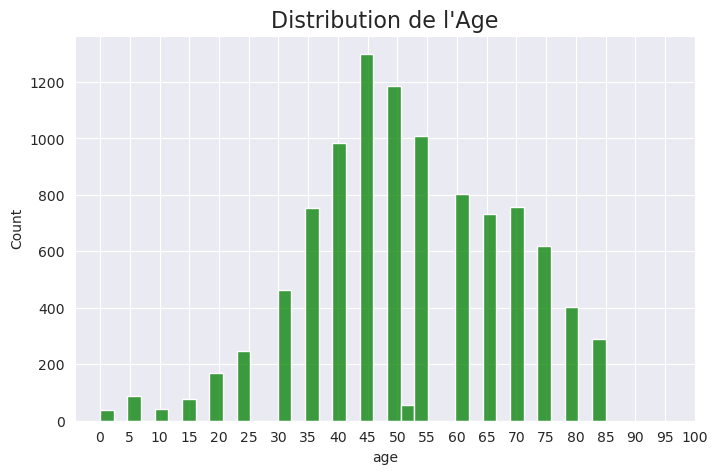

In [21]:
sns.set_style("darkgrid")
plt.figure(figsize=(8,5))
plt.title("Distribution de l'Age",fontsize=16)
sns.histplot(ham_df['age'], color= 'green')
#plt.title('Overall Distribution')
plt.xticks(list(range(0,105,5)))

plt.show()

## 6.3 Distribution d'Age par Sexe

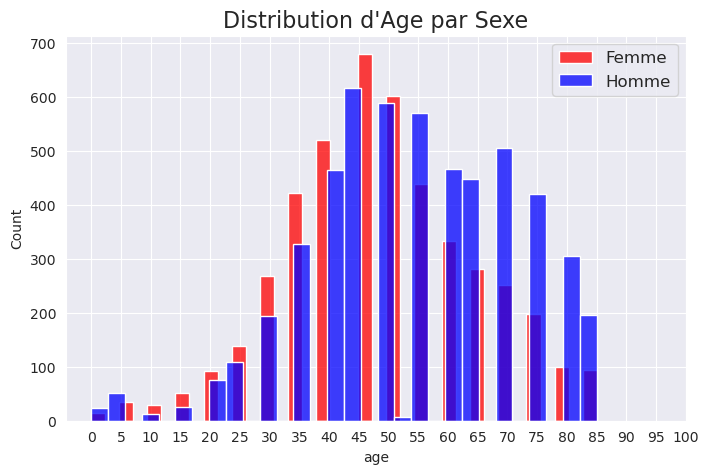

In [22]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.histplot(ham_df[ham_df['sex']=='female']['age'], 
             label='Femme', 
             color="r",
             kde_kws=dict(linewidth=2.5))
sns.histplot(ham_df[ham_df['sex']=='male']['age'], 
             label='Homme', 
             color="b",
             kde_kws=dict(linewidth=2.5))

plt.title("Distribution d'Age par Sexe",fontsize=16)
plt.xticks(list(range(0,105,5)))
plt.legend(loc='upper right', fontsize='12')
plt.show()

## 6.4 Comptage des types de cellules par Sexe

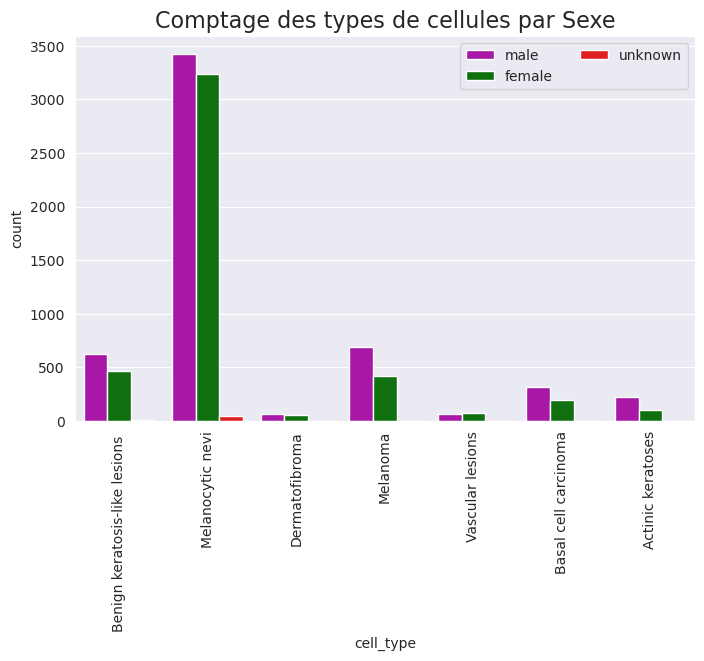

In [23]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.countplot(x='cell_type',  
              hue='sex', 
              palette=['m', 'g', 'r'],
              data=ham_df)
plt.legend(loc='upper right', ncol =2)  
plt.xticks(rotation = 90) 
plt.title('Comptage des types de cellules par Sexe',fontsize=16)
plt.show()

### 6.4.1
Il y a 57 valeurs inconnues pour le sexe, mais ce n'est pas un facteur important pour ce projet, donc on les laissera telles quelles.

In [24]:
print(ham_df.groupby('sex')['age'].count())

sex
female     4552
male       5406
unknown      57
Name: age, dtype: int64


## 6.5  Type de Lesion par Age and Sexe

D'après ce graphique, il semble que les femmes ont tendance à développer des lésions à un âge plus précoce que les hommes pour toutes les catégories. Cependant, étant donné que la moyenne d'âge des échantillons, 6.6.1, pour les femmes est de 48,7 ans, alors que la moyenne pour les hommes est de 54,5 ans, cela pourrait expliquer cette différence.

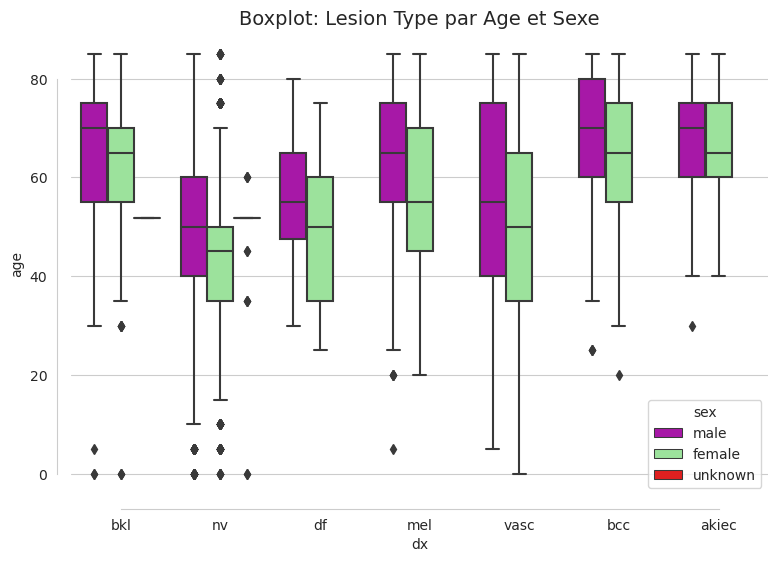

In [25]:
plt.figure(figsize=(9, 6))
sns.set_style("whitegrid")
sns.boxplot(x='dx', y='age',
            hue='sex', palette=['m', 'lightgreen', 'r'],
            data=ham_df)
plt.title('Boxplot: Lesion Type par Age et Sexe',fontsize=14)
sns.despine(offset=10, trim=True)

### 6.6.1

In [26]:
ham_df.groupby('sex')['age'].mean()

sex
female     48.714292
male       54.542394
unknown    49.343858
Name: age, dtype: float64

## 6.7 CountPlot: Comptage des types de cellules par Age

Les nævi mélanocytaires représentent 67% des données. <br>
Le graphique montre que la plupart des données de nævi mélanocytaires sont concentrées sur les âges < 55 ans, tandis que la plupart des échantillons d'âge pour le carcinome basocellulaire, le mélanome, les kératoses actiniques et les lésions bénignes de type kératose se situent dans la plage d'âge >= 55 ans.

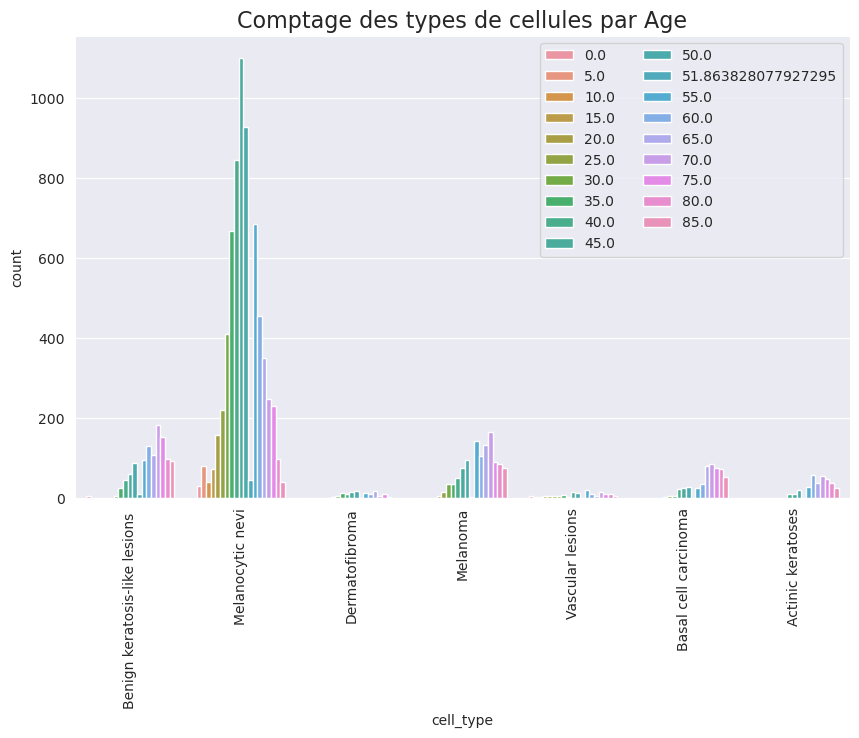

In [27]:
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
sns.countplot(x='cell_type',  #cell_type
              hue='age',
              data=ham_df)
plt.legend(loc='upper right', ncol =2) # , framealpha=0.5 
plt.xticks(rotation = 90) 
plt.title('Comptage des types de cellules par Age',fontsize=16)
plt.show()

# 7. Redimensionnement des images<br>

## 7.1 Comparaison des caractéristiques de taille d'image<br>
   
     Comparer la résolution des images redimensionnées : 600x450 vs 160x120. 
Les comparaisons d'images (7.1.1 et 7.1.2) montrent une réduction de la résolution. Dans quelle mesure l'utilisation d'une image redimensionnée de 160x120 par rapport à la taille originale a affecté l'accuracy du tests.

In [28]:
from PIL import Image

img_ISIC_0032258 = Image.open('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0032258.jpg')
img_ISIC_0032259 = Image.open('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0032259.jpg')

img_ISIC_0032258_160x120 = img_ISIC_0032258.resize((160,120), resample=Image.Resampling.LANCZOS)
img_ISIC_0032258_160x120.save('/kaggle/working/img_ISIC_0032258_160x120.jpg')

img_ISIC_0032259_160x120 = img_ISIC_0032259.resize((160,120), resample=Image.Resampling.LANCZOS)
img_ISIC_0032259_160x120.save('/kaggle/working/img_ISIC_0032259_160x120.jpg')



### 7.1.1 Image ISIC_0032258.jpg

RGB JPEG


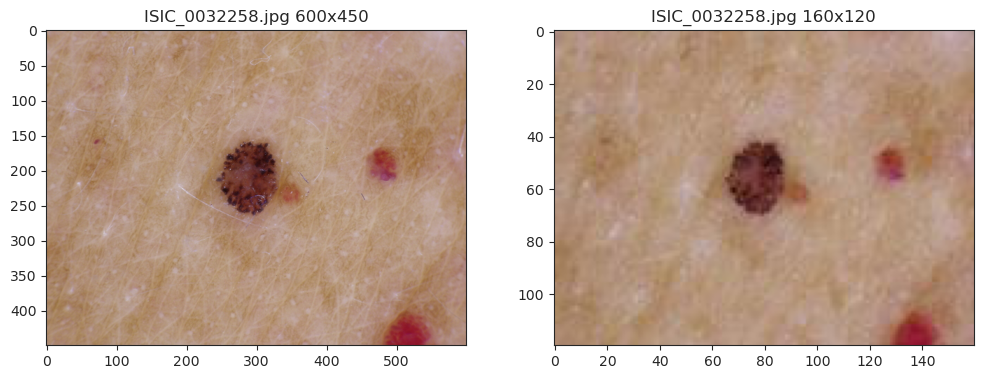

In [29]:
sns.set_style("ticks")
from PIL import Image
plt.figure(figsize=(12, 9))

plt.subplot(2,2,1)
imSize1 = Image.open('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0032258.jpg')
plt.title('ISIC_0032258.jpg 600x450')
plt.imshow(imSize1)

plt.subplot(2,2,2)
ISIC_0032258_160x120 = Image.open('/kaggle/working/img_ISIC_0032258_160x120.jpg')
plt.title('ISIC_0032258.jpg 160x120')
plt.imshow(ISIC_0032258_160x120)

print(imSize1.mode, imSize1.format)
plt.show()

### 7.1.2 Image ISIC_0032259.jpg

RGB JPEG


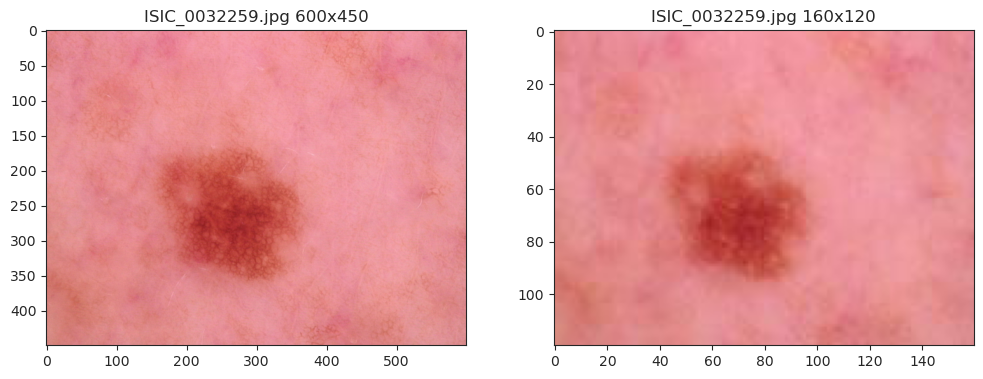

In [30]:
plt.figure(figsize=(12, 9))

plt.subplot(2,2,1)
imSize2 = Image.open('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0032259.jpg')
plt.imshow(imSize2)
plt.title('ISIC_0032259.jpg 600x450')
plt.imshow(imSize2)

plt.subplot(2,2,2)
ISIC_0032259_160x120 = Image.open('/kaggle/working/img_ISIC_0032259_160x120.jpg')
plt.title('ISIC_0032259.jpg 160x120')
plt.imshow(ISIC_0032259_160x120)

print(imSize2.mode, imSize2.format)
plt.show()

## 7.2 Redimensionnement des images pour l'Output du model

Utilisons la méthode .resize (width, height) pour produire une forme d'input (height, width, channels) de l'image.<br>
Nous avons opté pour une taille d'image de **160x120**.<br> 
La forme d'input (120, 160, 3) combine entre la vitesse, la résolution et la limite de mémoire.

In [31]:
ham_df['image'] = ham_df['path'].map(lambda x: np.asarray(Image.open(x).resize((160,120)))) # 

In [32]:
print(ham_df['image'].map(lambda x: x.shape))

0        (120, 160, 3)
1        (120, 160, 3)
2        (120, 160, 3)
3        (120, 160, 3)
4        (120, 160, 3)
             ...      
10010    (120, 160, 3)
10011    (120, 160, 3)
10012    (120, 160, 3)
10013    (120, 160, 3)
10014    (120, 160, 3)
Name: image, Length: 10015, dtype: object


## 7.3 Echantillon des images skin lesion 
 Adapté de: https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html

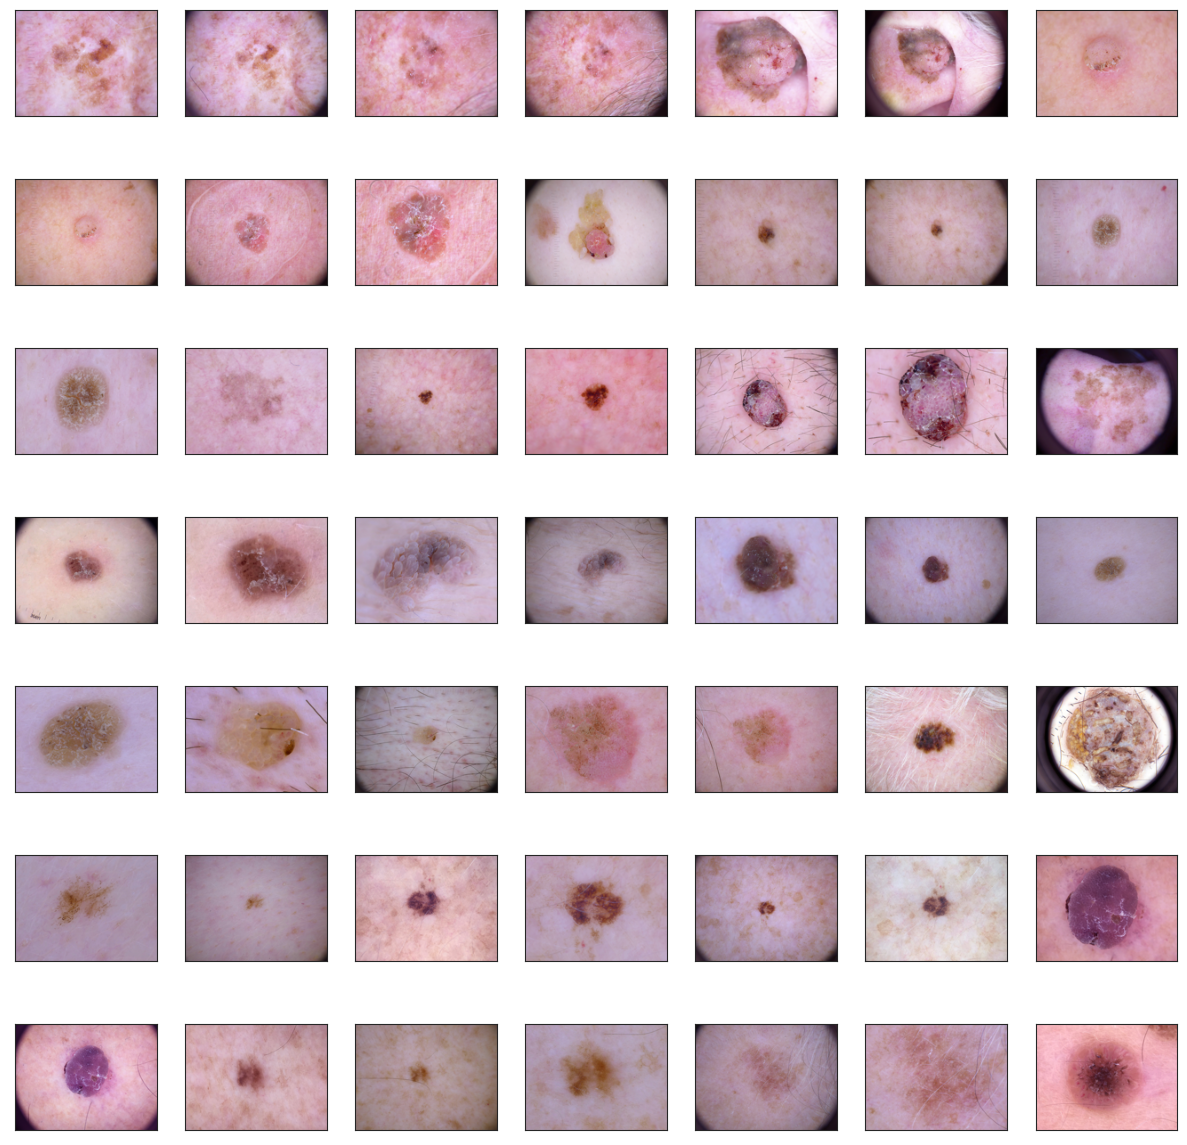

In [33]:
sns.set_style("ticks")
plt.figure(figsize=(15,15))
for i in range(49):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(ham_df['image'][i])
    
plt.show()

# 8 Prétraitement
Les processus suivants dans cette section ont été sourcés ou adaptés à partir de ces sites et notes.<br>
https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python<br>
https://github.com/00chengh/Skin-Cancer-HAM10000/blob/master/Final%20Capstone%20-%20Skin%20Cancer.ipynb<br>
https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy<br>
https://www.kaggle.com/hashbanger/skin-lesion-identification<br>
https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/<br>

##### Normaliser ou standardiser les pixels de l'image
La standardisation par Feature a été choisie plutôt que la normalisation. Bien que j'aie essayé la normalisation également, j'ai opté pour le choix que d'autres avaient déjà appliqué. Les deux sont essentiellement équivalents lorsqu'on considère de petites images en niveaux de gris, mais la standardisation est probablement un meilleur choix pour les grandes images en couleur. La standardisation utilise des statistiques de moyenne et d'écart-type, tandis que la normalisation met à l'échelle les valeurs de pixels dans une plage de 0 à 1 à partir d'une plage de 0 à 255.

In [34]:
features=ham_df.drop(columns=['cell_type_idx'],axis=1)
target=ham_df['cell_type_idx']

## 8.1 Entraînement Test Validation

### 8.1.1 Split: train / test = 80 / 20 

In [35]:
trainX, testX, trainY, testY = train_test_split(features, target, test_size=0.20,random_state=1234)

### 8.1.2 Conversion en tableau Numpy

In [36]:
x_train = np.asarray(trainX['image'].tolist())
x_test = np.asarray(testX['image'].tolist())

### 8.1.3 Standardisation

In [37]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std


### 8.1.4 Encodage one-hot : conversion de l'output to_categorical crossentropy

In [38]:
y_train = to_categorical(trainY, 7)
y_test = to_categorical(testY, 7)

### 8.1.5 Split: train / validation = 0.87 / 0.13
     J'ai choisi une taille de validation de 13% de l'ensemble d'entraînement. J'ai obtenu des résultats légèrement meilleurs qu'en utilisant une répartition de 90/10 et d'autres répartitions.

In [39]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.13, random_state = 2)

### 8.1.6 Reshape les images en 3 dimensions 

In [40]:
x_train = x_train.reshape(x_train.shape[0], *(120, 160, 3))
x_test = x_test.reshape(x_test.shape[0], *(120, 160, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(120, 160, 3))

#### 8.1.6.1 Confirmer le shape

In [41]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(x_validate.shape)

(6970, 120, 160, 3)
(6970, 7)
(2003, 120, 160, 3)
(1042, 120, 160, 3)


# 9. Test Model
   
   Cette section comprend un model CNN de test. Le model de test a été fourni principalement comme un 1er exemple.

## 9.1 Test Model Architecture

In [42]:
# CNN Model Architecture
input_shape = (120, 160, 3)
num_classes = 7

modelT = Sequential()
modelT.add(Conv2D(16, (3, 3), padding='same',input_shape=input_shape, activation='relu'))
modelT.add(BatchNormalization())
modelT.add(MaxPooling2D(2, 2))
modelT.add(Dropout(0.25))

modelT.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
modelT.add(BatchNormalization())
modelT.add(MaxPooling2D(2, 2))
modelT.add(Dropout(0.25))

modelT.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
modelT.add(BatchNormalization())
modelT.add(MaxPooling2D(2, 2))
modelT.add(Dropout(0.25))

modelT.add(Flatten())
modelT.add(Dense(128, activation='relu'))
modelT.add(BatchNormalization())
modelT.add(Dropout(0.5))

modelT.add(Dense(num_classes, activation='softmax'))

modelT.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=["accuracy"])
modelT.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 160, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 120, 160, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 80, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 80, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 80, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 60, 80, 32)       1

### 9.1.1 Entrainement du Test Model 

In [43]:
Epochs=20
batchSize=64
t0=time.time()
# model fit

print('------------------------------------------')
print('Running Model T.')
print('------------------------------------------')
ModelT = modelT.fit(x_train, y_train, 
                    validation_data=(x_test, y_test), 
                    epochs=Epochs, 
                    batch_size=batchSize, 
                    verbose=1)

print('------------------------------------------')
t1=time.time()
print(t1-t0," seconds")

------------------------------------------
Running Model T.
------------------------------------------
Epoch 1/20
109/109 [==============================] - 144s 1s/step - loss: 1.7866 - accuracy: 0.4656 - val_loss: 1.5502 - val_accuracy: 0.5212
Epoch 2/20
109/109 [==============================] - 129s 1s/step - loss: 1.0994 - accuracy: 0.6506 - val_loss: 1.7021 - val_accuracy: 0.6570
Epoch 3/20
109/109 [==============================] - 129s 1s/step - loss: 0.8838 - accuracy: 0.6966 - val_loss: 1.1154 - val_accuracy: 0.6835
Epoch 4/20
109/109 [==============================] - 129s 1s/step - loss: 0.7961 - accuracy: 0.7215 - val_loss: 1.7071 - val_accuracy: 0.6845
Epoch 5/20
109/109 [==============================] - 146s 1s/step - loss: 0.7481 - accuracy: 0.7353 - val_loss: 1.1818 - val_accuracy: 0.6735
Epoch 6/20
109/109 [==============================] - 129s 1s/step - loss: 0.6969 - accuracy: 0.7544 - val_loss: 0.8897 - val_accuracy: 0.6975
Epoch 7/20
109/109 [===================

### 9.1.2 Evaluation Test Model

In [44]:
# Model T evaluation  
print('------------------------------------------')
print('Model T evaluation.')
print('------------------------------------------')
scores = modelT.evaluate(x_test, y_test, verbose=2)

print("CNN Error: %.2f%%" % (100-scores[1]*100))
print("CNN Acc: %.2f%%" % (scores[1]*100))

final_loss, final_acc = modelT.evaluate(x_test, y_test, verbose=0)
print("Final loss: {0:.4f}".format(final_loss, final_acc))

------------------------------------------
Model T evaluation.
------------------------------------------
63/63 - 8s - loss: 0.8010 - accuracy: 0.7544 - 8s/epoch - 134ms/step
CNN Error: 24.56%
CNN Acc: 75.44%
Final loss: 0.8010


### 9.1.3 Test Model Accuracy et Loss Plots

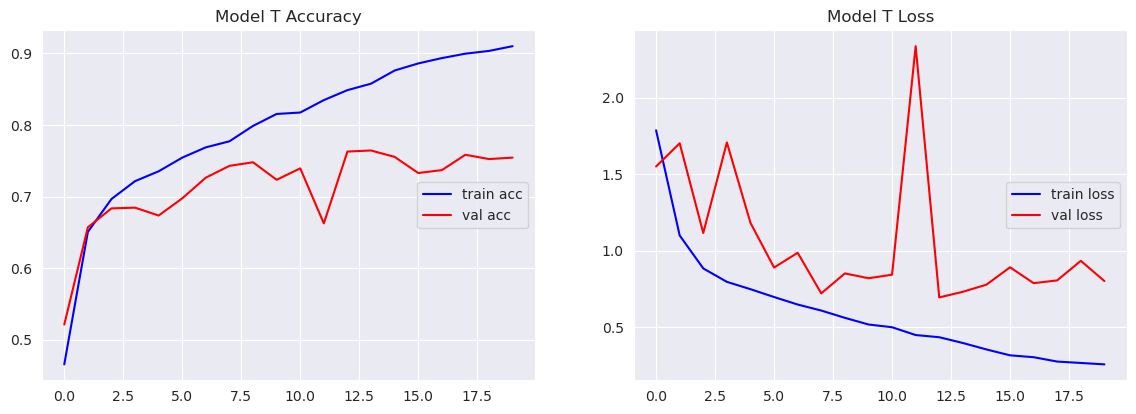

In [45]:
sns.set_style("darkgrid")
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(ModelT.history['accuracy'], 'b', label="Training accuracy")
plt.plot(ModelT.history['val_accuracy'], 'r', label="Validation accuracy")
plt.legend(['train acc', 'val acc'], loc='center right')
plt.title('Model T Accuracy')

plt.subplot(2,2,2)
plt.plot(ModelT.history['loss'], 'b', label= "Training loss")
plt.plot(ModelT.history['val_loss'], 'r', label="validation loss")
plt.legend(['train loss', 'val loss'], loc='center right')
plt.title('Model T Loss')
plt.show()